#Importing basic Python Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


EMA(200) + RSI(14)   
(May miss strong trend moves.)

No Restriction:5.06%  
Partial Restriction:12.36%  
Full Restriction: 5.25%

---

EMA(200) + EMA(50)  
(May result in more false signals in sideways markets.)

No Restriction:23.14%  
Partial Restriction:22.49%  
Full Restriction: -3.18%



#EMA 200 + RSI(14) Restricted by SL/TP adn End of the Day Exit

###Returns: 5.06%

/tmp/ipython-input-2-1260588048.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA_200'] = df['close'].ewm(span=200).mean()
/tmp/ipython-input-2-1260588048.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['RSI'] = compute_rsi(df['close'])
/tmp/ipython-input-2-1260588048.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand


✅ Final Capital: ₹210,129.55
📈 Total Return: 5.06%
📊 Total Trades: 227
✅ Win Rate: 58.15%


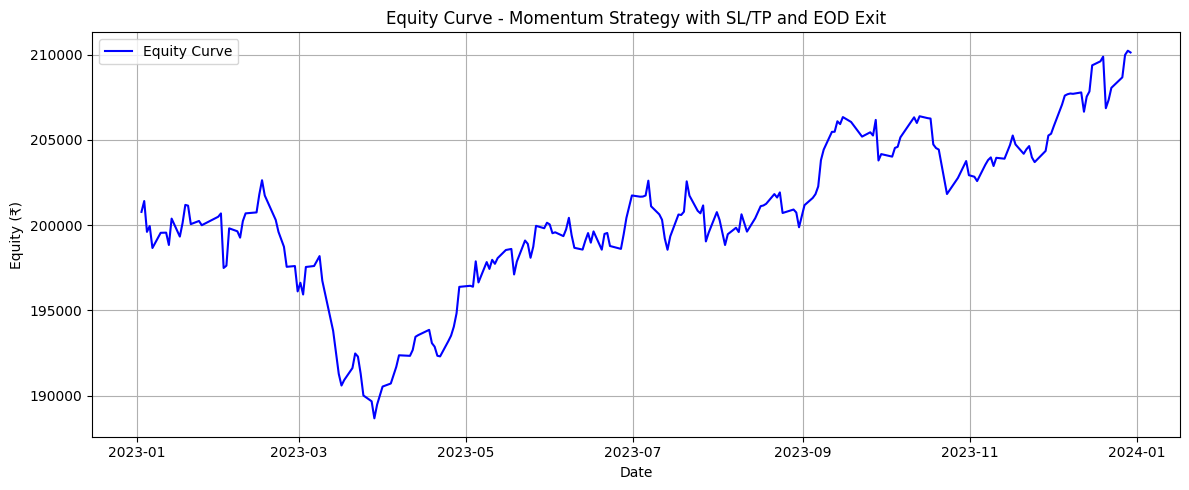

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Nifty data
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])  # assumes 'datetime' column is present
df.set_index('datetime', inplace=True)
df = df.between_time('09:15', '15:15')  # only trading hours

# Indicators
df['EMA_200'] = df['close'].ewm(span=200).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['close'])

# Signal generation
df['Buy_Signal'] = (df['close'] > df['EMA_200']) & (df['RSI'] > 50) & (df['RSI'].shift(1) <= 50)

# Initialize
capital = 200000
position = None
entry_price = 0
trades = []
qty = 0

# Run backtest
for date, row in df.iterrows():
    if position is None and row['Buy_Signal']:
        # Enter trade
        entry_price = row['close']
        qty = capital // entry_price
        position = {
            'entry_time': date,
            'entry_price': entry_price,
            'qty': qty
        }

    elif position is not None:
        # Calculate current PnL
        price = row['close']
        ret = (price - position['entry_price']) / position['entry_price']

        # Check exit conditions
        stop_loss_hit = ret <= -0.015
        take_profit_hit = ret >= 0.03
        force_exit = date.time().strftime("%H:%M") == "15:15"

        if stop_loss_hit or take_profit_hit or force_exit:
            exit_price = row['close']
            pnl = (exit_price - position['entry_price']) * position['qty']
            capital += pnl
            trades.append({
                'entry_time': position['entry_time'],
                'exit_time': date,
                'entry_price': position['entry_price'],
                'exit_price': exit_price,
                'qty': position['qty'],
                'pnl': pnl,
                'capital': capital
            })
            position = None

# Convert trade log to DataFrame
trades_df = pd.DataFrame(trades)

# Print results
total_return = (capital - 200000) / 200000 * 100
print(f"\n✅ Final Capital: ₹{capital:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Total Trades: {len(trades_df)}")
print(f"✅ Win Rate: {(trades_df['pnl'] > 0).sum() / len(trades_df) * 100:.2f}%")

# Plot equity curve
trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
trades_df['equity'] = 200000 + trades_df['cum_pnl']

plt.figure(figsize=(12, 5))
plt.plot(trades_df['exit_time'], trades_df['equity'], label='Equity Curve', color='blue')
plt.title("Equity Curve - Momentum Strategy with SL/TP and EOD Exit")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#EMA 200 + RSI(14) NO Restrictions

###Returns: 12.36%


✅ Final Capital: ₹224,728.75
📈 Total Return: 12.36%
📊 Total Trades: 3343
✅ Win Rate: 34.28%


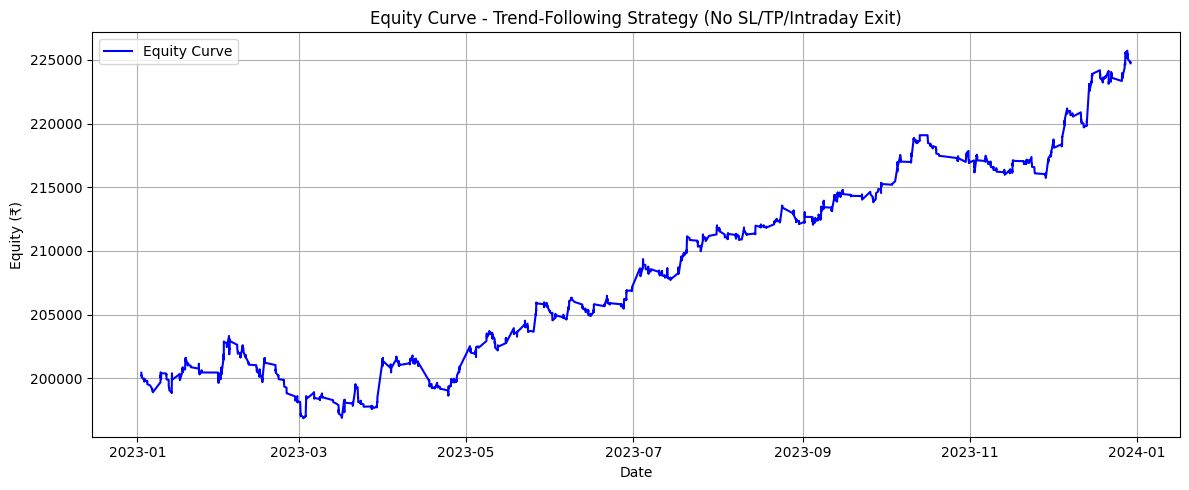

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load Nifty data
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Indicators
df['EMA_200'] = df['close'].ewm(span=200).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['close'])

# Generate Buy Signal
df['Buy_Signal'] = (df['close'] > df['EMA_200']) & (df['RSI'] > 50) & (df['RSI'].shift(1) <= 50)
# Generate Exit Signal
df['Exit_Signal'] = (df['close'] < df['EMA_200']) | (df['RSI'] < 50)

# Backtest variables
capital = 200000
position = None
qty = 0
trades = []

# Backtest loop
for date, row in df.iterrows():
    if position is None and row['Buy_Signal']:
        # Buy
        entry_price = row['close']
        qty = capital // entry_price
        position = {
            'entry_time': date,
            'entry_price': entry_price,
            'qty': qty
        }

    elif position is not None and row['Exit_Signal']:
        # Exit
        exit_price = row['close']
        pnl = (exit_price - position['entry_price']) * position['qty']
        capital += pnl
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': date,
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'qty': position['qty'],
            'pnl': pnl,
            'capital': capital
        })
        position = None

# If holding position till end of data, close it at last price
if position is not None:
    final_price = df['close'].iloc[-1]
    pnl = (final_price - position['entry_price']) * position['qty']
    capital += pnl
    trades.append({
        'entry_time': position['entry_time'],
        'exit_time': df.index[-1],
        'entry_price': position['entry_price'],
        'exit_price': final_price,
        'qty': position['qty'],
        'pnl': pnl,
        'capital': capital
    })

# Trade Log DataFrame
trades_df = pd.DataFrame(trades)

# Stats
total_return = (capital - 200000) / 200000 * 100
print(f"\n✅ Final Capital: ₹{capital:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Total Trades: {len(trades_df)}")
print(f"✅ Win Rate: {(trades_df['pnl'] > 0).sum() / len(trades_df) * 100:.2f}%")

# Plot equity curve
trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
trades_df['equity'] = 200000 + trades_df['cum_pnl']

plt.figure(figsize=(12, 5))
plt.plot(trades_df['exit_time'], trades_df['equity'], label='Equity Curve', color='blue')
plt.title("Equity Curve - Trend-Following Strategy (No SL/TP/Intraday Exit)")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#EMA 200 + RSI(14) Restricted by SL/TP and Intraday Restrictions

###Returns: 5.25%


✅ Final Capital: ₹210,505.75
📈 Total Return: 5.25%
📊 Total Trades: 225
✅ Win Rate: 56.00%


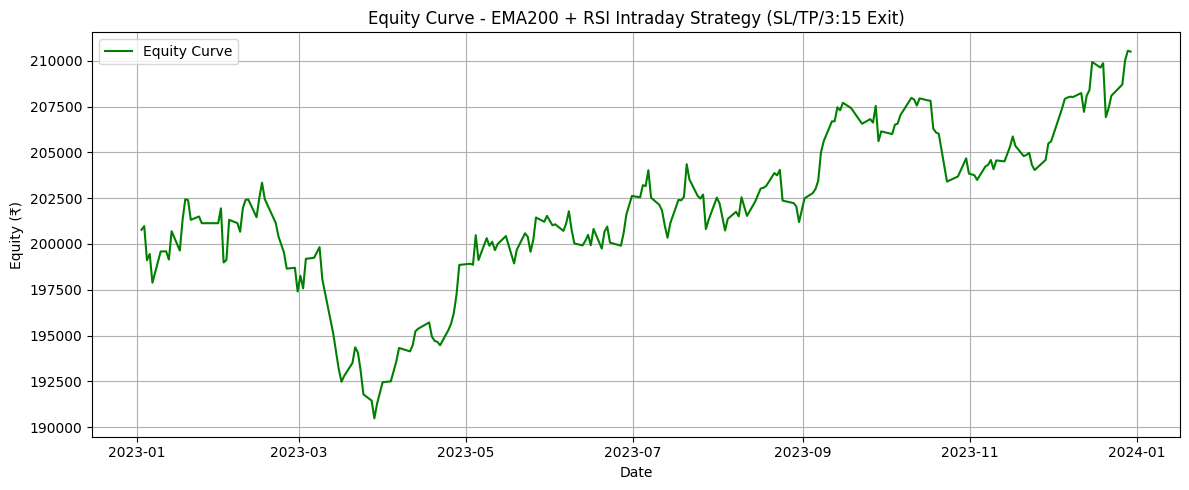

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Technical indicators
df['EMA_200'] = df['close'].ewm(span=200).mean()

def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df['RSI'] = compute_rsi(df['close'])

# Buy signal: close above EMA 200 and RSI crosses above 50
df['Buy_Signal'] = (df['close'] > df['EMA_200']) & (df['RSI'] > 50) & (df['RSI'].shift(1) <= 50)

# Backtest setup
capital = 200000
position = None
trades = []
stop_loss_pct = 0.015
take_profit_pct = 0.03

for date, row in df.iterrows():
    time = date.time()

    # Entry condition (buy)
    if position is None and row['Buy_Signal'] and time < pd.to_datetime("15:00").time():
        entry_price = row['close']
        qty = capital // entry_price
        position = {
            'entry_time': date,
            'entry_price': entry_price,
            'qty': qty,
            'max_price': entry_price,
            'min_price': entry_price
        }

    # If position is open
    if position is not None:
        current_price = row['close']
        sl_price = position['entry_price'] * (1 - stop_loss_pct)
        tp_price = position['entry_price'] * (1 + take_profit_pct)

        # Update max/min for debugging or trailing logic (optional)
        position['max_price'] = max(position['max_price'], current_price)
        position['min_price'] = min(position['min_price'], current_price)

        # SL or TP hit
        if current_price <= sl_price:
            reason = 'Stop-Loss'
        elif current_price >= tp_price:
            reason = 'Take-Profit'
        elif time >= pd.to_datetime("15:15").time():
            reason = 'Force Exit'
        else:
            continue  # hold position

        # Exit trade
        pnl = (current_price - position['entry_price']) * position['qty']
        capital += pnl
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': date,
            'entry_price': position['entry_price'],
            'exit_price': current_price,
            'qty': position['qty'],
            'pnl': pnl,
            'capital': capital,
            'exit_reason': reason
        })
        position = None

# Trade log
trades_df = pd.DataFrame(trades)

# Performance summary
total_return = (capital - 200000) / 200000 * 100
print(f"\n✅ Final Capital: ₹{capital:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Total Trades: {len(trades_df)}")
print(f"✅ Win Rate: {(trades_df['pnl'] > 0).sum() / len(trades_df) * 100:.2f}%")

# Equity curve
trades_df['cum_pnl'] = trades_df['pnl'].cumsum()
trades_df['equity'] = 200000 + trades_df['cum_pnl']

plt.figure(figsize=(12, 5))
plt.plot(trades_df['exit_time'], trades_df['equity'], label='Equity Curve', color='green')
plt.title("Equity Curve - EMA200 + RSI Intraday Strategy (SL/TP/3:15 Exit)")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#EMA 200 + EMA(50) NO Restrictions

###Returns: 23.14%


🔹SMA Crossover Without SL/TP
✅ Final Capital: ₹246,289.35
📈 Total Return: 23.14%
📊 Total Trades: 242
✅ Win Rate: 31.82%


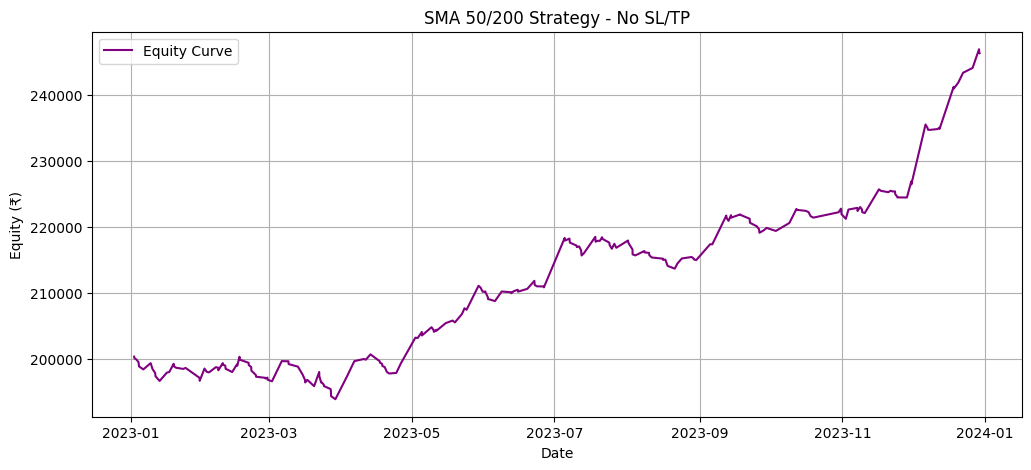

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Indicators
df['EMA_50'] = df['close'].ewm(span=50).mean()
df['EMA_200'] = df['close'].ewm(span=200).mean()

# Crossover signals
df['Buy_Signal'] = (df['EMA_50'] > df['EMA_200']) & (df['EMA_50'].shift(1) <= df['EMA_200'].shift(1))
df['Sell_Signal'] = (df['EMA_50'] < df['EMA_200']) & (df['EMA_50'].shift(1) >= df['EMA_200'].shift(1))

# Backtest
capital = 200000
position = None
qty = 0
trades = []

for date, row in df.iterrows():
    if position is None and row['Buy_Signal']:
        entry_price = row['close']
        qty = capital // entry_price
        position = {
            'entry_time': date,
            'entry_price': entry_price,
            'qty': qty
        }

    elif position is not None and row['Sell_Signal']:
        exit_price = row['close']
        pnl = (exit_price - position['entry_price']) * position['qty']
        capital += pnl
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': date,
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'qty': position['qty'],
            'pnl': pnl,
            'capital': capital
        })
        position = None

# Final exit if holding
if position is not None:
    final_price = df['close'].iloc[-1]
    pnl = (final_price - position['entry_price']) * position['qty']
    capital += pnl
    trades.append({
        'entry_time': position['entry_time'],
        'exit_time': df.index[-1],
        'entry_price': position['entry_price'],
        'exit_price': final_price,
        'qty': position['qty'],
        'pnl': pnl,
        'capital': capital
    })

trades_df = pd.DataFrame(trades)

# Summary
total_return = (capital - 200000) / 200000 * 100
print(f"\n🔹SMA Crossover Without SL/TP")
print(f"✅ Final Capital: ₹{capital:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Total Trades: {len(trades_df)}")
print(f"✅ Win Rate: {(trades_df['pnl'] > 0).mean() * 100:.2f}%")

# Plot
trades_df['equity'] = 200000 + trades_df['pnl'].cumsum()
plt.figure(figsize=(12, 5))
plt.plot(trades_df['exit_time'], trades_df['equity'], label='Equity Curve', color='purple')
plt.title("SMA 50/200 Strategy - No SL/TP")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.show()


#EMA 200 + EMA(50) ALL Restrictions

###Returns: -3.18%


🔹EMA Crossover With SL/TP + Intraday Exit
✅ Final Capital: ₹193,643.35
📈 Total Return: -3.18%
📊 Total Trades: 157
✅ Win Rate: 49.04%


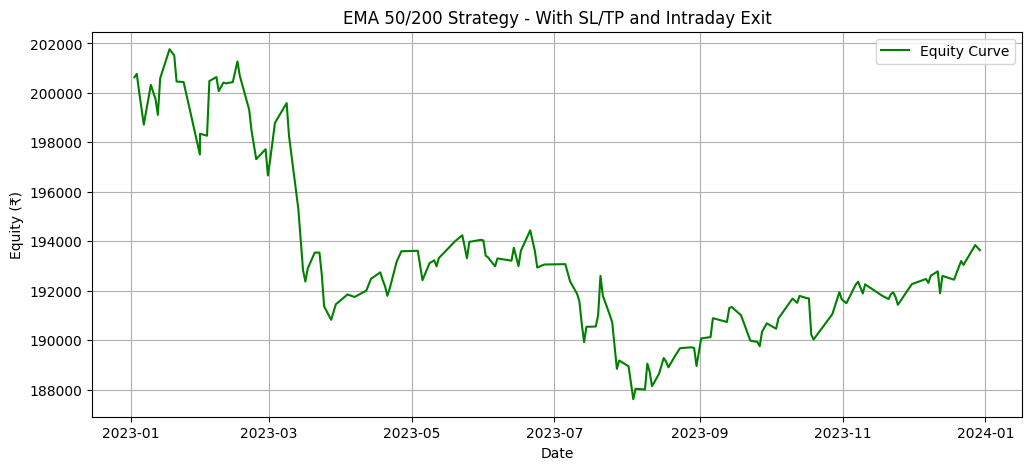

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and prepare data
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

# Indicators
df['EMA_50'] = df['close'].ewm(span=50).mean()
df['EMA_200'] = df['close'].ewm(span=200).mean()

# Crossover signals
df['Buy_Signal'] = (df['EMA_50'] > df['EMA_200']) & (df['EMA_50'].shift(1) <= df['EMA_200'].shift(1))
df['Sell_Signal'] = (df['EMA_50'] < df['EMA_200']) & (df['EMA_50'].shift(1) >= df['EMA_200'].shift(1))

# Backtest
capital = 200000
position = None
qty = 0
trades = []

# Add this before loop
df = df.between_time('09:15', '15:15')  # Filter trading hours

for date, row in df.iterrows():
    if position is None and row['Buy_Signal']:
        entry_price = row['close']
        qty = capital // entry_price
        position = {
            'entry_time': date,
            'entry_price': entry_price,
            'qty': qty
        }

    elif position is not None:
        price = row['close']
        ret = (price - position['entry_price']) / position['entry_price']
        stop_loss = ret <= -0.015
        take_profit = ret >= 0.03
        force_exit = date.time().strftime("%H:%M") == "15:15"

        if stop_loss or take_profit or force_exit:
            exit_price = row['close']
            pnl = (exit_price - position['entry_price']) * position['qty']
            capital += pnl
            trades.append({
                'entry_time': position['entry_time'],
                'exit_time': date,
                'entry_price': position['entry_price'],
                'exit_price': exit_price,
                'qty': position['qty'],
                'pnl': pnl,
                'capital': capital
            })
            position = None

# Final exit
if position is not None:
    final_price = df['close'].iloc[-1]
    pnl = (final_price - position['entry_price']) * position['qty']
    capital += pnl
    trades.append({
        'entry_time': position['entry_time'],
        'exit_time': df.index[-1],
        'entry_price': position['entry_price'],
        'exit_price': final_price,
        'qty': position['qty'],
        'pnl': pnl,
        'capital': capital
    })

# Output
trades_df = pd.DataFrame(trades)
total_return = (capital - 200000) / 200000 * 100
print(f"\n🔹EMA Crossover With SL/TP + Intraday Exit")
print(f"✅ Final Capital: ₹{capital:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Total Trades: {len(trades_df)}")
print(f"✅ Win Rate: {(trades_df['pnl'] > 0).mean() * 100:.2f}%")

# Plot
trades_df['equity'] = 200000 + trades_df['pnl'].cumsum()
plt.figure(figsize=(12, 5))
plt.plot(trades_df['exit_time'], trades_df['equity'], label='Equity Curve', color='green')
plt.title("EMA 50/200 Strategy - With SL/TP and Intraday Exit")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.show()


#EMA 200 + EMA(50) Intraday Exit

###Returns: 22.49%

/tmp/ipython-input-7-3047498809.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA_50'] = df['close'].ewm(span=50).mean()
/tmp/ipython-input-7-3047498809.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['EMA_200'] = df['close'].ewm(span=200).mean()
/tmp/ipython-input-7-3047498809.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat


🔹EMA Crossover WITHOUT SL/TP
✅ Final Capital: ₹244,975.10
📈 Total Return: 22.49%
📊 Total Trades: 231
✅ Win Rate: 32.03%


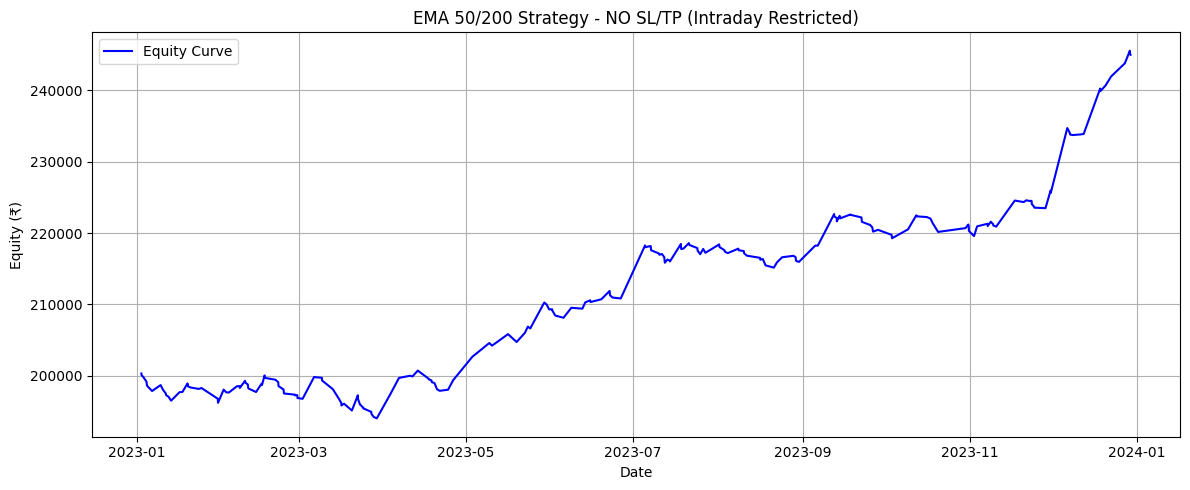

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load and filter intraday data
df = pd.read_csv('/content/spot_with_signals_2023.csv')
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)
df = df.between_time('09:15', '15:15')  # Intraday restriction

# Indicators
df['EMA_50'] = df['close'].ewm(span=50).mean()
df['EMA_200'] = df['close'].ewm(span=200).mean()

# Crossover signals
df['Buy_Signal'] = (df['EMA_50'] > df['EMA_200']) & (df['EMA_50'].shift(1) <= df['EMA_200'].shift(1))
df['Sell_Signal'] = (df['EMA_50'] < df['EMA_200']) & (df['EMA_50'].shift(1) >= df['EMA_200'].shift(1))

# Backtest
capital = 200000
position = None
qty = 0
trades = []

for date, row in df.iterrows():
    if position is None and row['Buy_Signal']:
        entry_price = row['close']
        qty = capital // entry_price
        position = {
            'entry_time': date,
            'entry_price': entry_price,
            'qty': qty
        }

    elif position is not None and row['Sell_Signal']:
        exit_price = row['close']
        pnl = (exit_price - position['entry_price']) * position['qty']
        capital += pnl
        trades.append({
            'entry_time': position['entry_time'],
            'exit_time': date,
            'entry_price': position['entry_price'],
            'exit_price': exit_price,
            'qty': position['qty'],
            'pnl': pnl,
            'capital': capital
        })
        position = None

# Final forced exit if holding position
if position is not None:
    final_price = df['close'].iloc[-1]
    pnl = (final_price - position['entry_price']) * position['qty']
    capital += pnl
    trades.append({
        'entry_time': position['entry_time'],
        'exit_time': df.index[-1],
        'entry_price': position['entry_price'],
        'exit_price': final_price,
        'qty': position['qty'],
        'pnl': pnl,
        'capital': capital
    })

# Results
trades_df = pd.DataFrame(trades)
total_return = (capital - 200000) / 200000 * 100
print(f"\n🔹EMA Crossover WITHOUT SL/TP")
print(f"✅ Final Capital: ₹{capital:,.2f}")
print(f"📈 Total Return: {total_return:.2f}%")
print(f"📊 Total Trades: {len(trades_df)}")
print(f"✅ Win Rate: {(trades_df['pnl'] > 0).mean() * 100:.2f}%")

# Plot
trades_df['equity'] = 200000 + trades_df['pnl'].cumsum()
plt.figure(figsize=(12, 5))
plt.plot(trades_df['exit_time'], trades_df['equity'], label='Equity Curve', color='blue')
plt.title("EMA 50/200 Strategy - NO SL/TP (Intraday Restricted)")
plt.xlabel("Date")
plt.ylabel("Equity (₹)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
